## Analyzing a scene

We are going to apply the different capabilities build in order to predict actors in a scene

### Importing libraries

In [ ]:
import sys
import os
import json
import pandas as pd
import numpy as np
!pip install pandasql
from pandasql import sqldf
import matplotlib.pyplot as plt
from time import time, strftime, localtime, gmtime
sys.path.append('/opt/workspace/src/python_scripts/')
from ops_face_recognition import train_recognizer,get_probabilities_for_folder
from ops_files_operations import read_pickle_file, read_json_file, get_element_from_metadata
from ops_face_detection import process_video, get_video_embeddings,get_frame_from_video, get_embeddings_from_image
from ops_results_interpretation import get_frames_df, get_actors_probs_query, get_predicted_timeline, get_summarized_timeline

### Creating best recognizers

Based on the results obtained in Notebook "10_training_models"

In [ ]:
embeddings_folder = './models/embeddings/actor_faces'
recognizer_path = './models/recognizers'

#### Linear recognizer

In [ ]:
train_recognizer(
    embeddings_folder=embeddings_folder,
    model_id = None,
    C=1.0,
    kernel='linear',
    probability=True,
    save_to_pickle=True,
    output_folder=recognizer_path
)

#### RBF recognizer

In [ ]:
train_recognizer(
    embeddings_folder=embeddings_folder,
    model_id = None,
    kernel='rbf',
    C=1.0,
    gamma=1.0,
    probability=True,
    save_to_pickle=True,
    output_folder=recognizer_path
)

#### Poly recognizer

In [ ]:
train_recognizer(
    embeddings_folder=embeddings_folder,
    model_id = None,
    kernel='poly',
    C=1.0,
    degree=3,
    probability=True,
    save_to_pickle=True,
    output_folder=recognizer_path
)

#### Getting recognizers ids

In [ ]:
recognizers_metadata_path = './models/recognizers/recognizer_metadata.json'
linear_recognizer_id = get_element_from_metadata(
    metadata_file_path=recognizers_metadata_path,
    key='kernel',
    value='linear',
    latest=True
)["recognizer_id"]
rbf_recognizer_id = get_element_from_metadata(
    metadata_file_path=recognizers_metadata_path,
    key='kernel',
    value='rbf',
    latest=True
)["recognizer_id"]
poly_recognizer_id = get_element_from_metadata(
    metadata_file_path=recognizers_metadata_path,
    key='kernel',
    value='poly',
    latest=True
)["recognizer_id"]
print(f'Linear = {linear_recognizer_id}, rbf = {rbf_recognizer_id}, poly = {poly_recognizer_id}.')

### Processing a scene

#### Obtaining scene embeddings

In [ ]:
scene_path = './datasets/videos/the_final_kick.mp4'
output_path = './models/embeddings/processed_videos'
get_video_embeddings(
    video_path = scene_path,
    results_path = output_path,
    partitions=4, 
    desired_fps=4
)

#### Getting embeddings "processed_video_id"

In [ ]:
probs_metadata_path = './models/embeddings/processed_videos/the_final_kick/processed_videos_metadata.json'
processed_video_id = get_element_from_metadata(
    metadata_file_path=probs_metadata_path,
    latest=True
)["processed_video_id"]
print(f'Processed video id = {processed_video_id}.')

#### Predicting results for that scene

In [ ]:
scene_embeddings_path = './models/embeddings/processed_videos/the_final_kick'
results_folder = './models/results'
folder_probabilities, folder_probabilities_metadata = get_probabilities_for_folder(
    folder_path = scene_embeddings_path,
    recognizer_folder = recognizer_path,
    save_to_pickle = True,
    output_folder = results_folder,
    processed_video_id = processed_video_id,
    recognizer_id = linear_recognizer_id
)

In [ ]:
results_id = folder_probabilities_metadata['results_id']
results_id

### Understanding results for one actor

The following is a walkthrough around the process to determine wether an actor is present or not in a specific timestamp of a video

#### Getting results dict

In [53]:
results_metadata_path = './models/results/probabilities_metadata.json'
results_metadata = get_element_from_metadata(
    metadata_file_path=results_metadata_path,
    #key = 'results_id',
    #value = results_id,
    latest=True
)
pickle_path = results_metadata['pickle_path']
results = read_pickle_file(pickle_path)

In [54]:
processed_videos_metadata_path = './models/embeddings/processed_videos/the_final_kick/processed_videos_metadata.json'
recognizer_metadata_path = './models/recognizers/recognizer_metadata.json'
processed_videos_metadata = get_element_from_metadata(
    metadata_file_path=processed_videos_metadata_path,
    key = 'processed_video_id',
    value = results_metadata['processed_video_id']
)
recognizer_metadata = get_element_from_metadata(
    metadata_file_path=recognizer_metadata_path,
    key = 'recognizer_id',
    value = results_metadata['recognizer_id']
)

#### Transforming dict into pd dataframe

In [55]:
full_probs = []
for chunk in results:
    for preds in chunk["probabilities"]:
        preds_dict= {}
        preds_dict["frame_number"] = preds["frame_number"]
        preds_dict["timestamp"] = preds["timestamp"]
        preds_dict["pred_1_name"] = sorted(preds["predictions"][0], key=preds["predictions"][0].get, reverse=True)[0]
        preds_dict["pred_1_value"] = preds["predictions"][0][preds_dict["pred_1_name"]]
        preds_dict["pred_2_name"] = sorted(preds["predictions"][0], key=preds["predictions"][0].get, reverse=True)[1]
        preds_dict["pred_2_value"] = preds["predictions"][0][preds_dict["pred_2_name"]]
        preds_dict["pred_3_name"] = sorted(preds["predictions"][0], key=preds["predictions"][0].get, reverse=True)[2]
        preds_dict["pred_3_value"] = preds["predictions"][0][preds_dict["pred_3_name"]]
        full_probs.append(preds_dict)

results_df = pd.DataFrame(full_probs)

#### Generating frames for the processed video

In [56]:
frames_df = get_frames_df(processed_videos_metadata)

#### Getting probs by frame for a single actor

In [57]:
actor = '2037_cillian_murphy'

q1 = ("""    
    select
        frame_number,
        coalesce(pred_1_value,0) as pred_1_value
        
    from frames_df
    left join results_df using(frame_number)
    where 
      (pred_1_name like '%{0}%' or pred_1_name is null)
""").format(actor)

q2 = ("""    
    select
        frame_number,
        coalesce(pred_2_value,0) as pred_2_value
        
    from frames_df
    left join results_df using(frame_number)
    where 
      (pred_2_name like '%{0}%' or pred_2_name is null)
""").format(actor)

q3 = get_actors_probs_query(actor)

actor_pred1 = sqldf(q1,globals())
actor_pred2 = sqldf(q2, globals())
actor_pred = sqldf(q3,globals())

#### Plotting the results

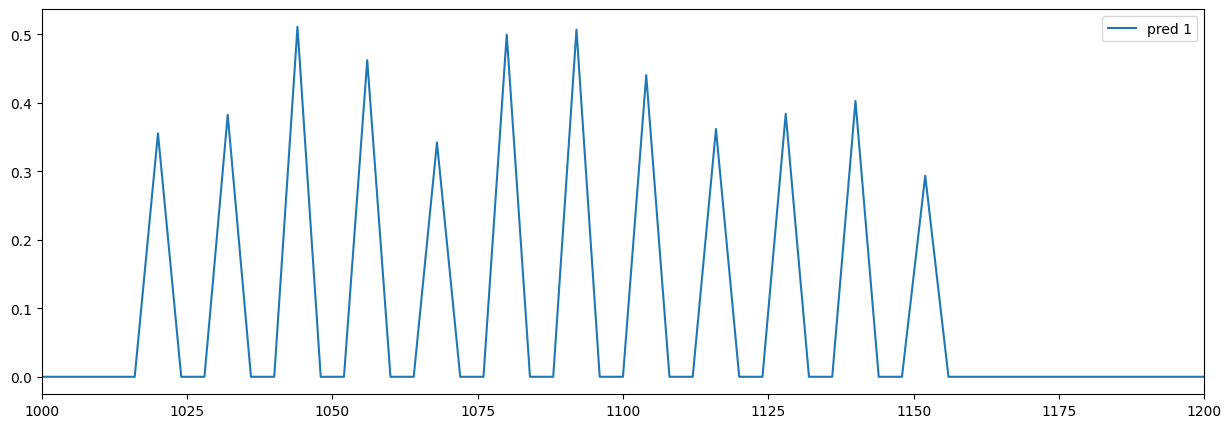

In [90]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.plot(actor_pred1['frame_number'], actor_pred1['pred_1_value'], label = "pred 1")
#plt.plot(actor_pred2['frame_number'], actor_pred2['pred_2_value'], label = "pred 2")
#plt.plot(actor_pred['frame_number'], actor_pred['pred_value'], label = "overall pred")
#plt.xlim(400, 500) 
plt.xlim(1000, 1200) 
#plt.xlim(1330, 1390)
#plt.xlim(300, 3000)
plt.legend()

#### Checking a specific frame/timestamp

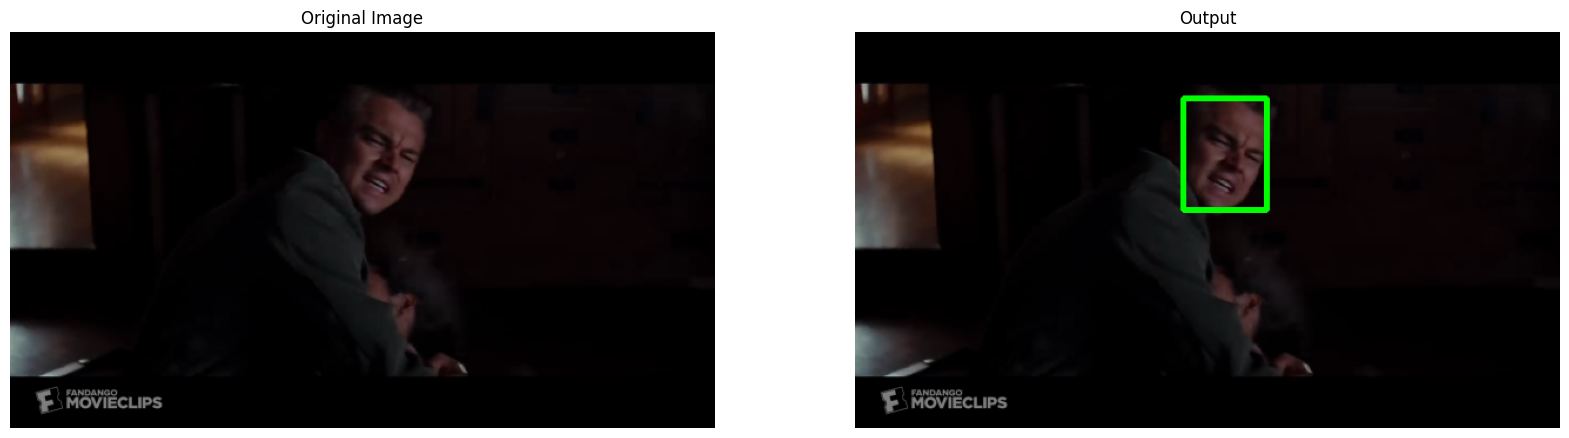

In [29]:
scene_path = './datasets/videos/the_final_kick.mp4'
frame = get_frame_from_video(video_path = scene_path,frame_number = 2450)#timestamp = '00:00:12.000')
embs, embs_metadata = get_embeddings_from_image(provided_image=frame, multiple_faces=True, display=True)

### Understanding results for all actors in a video

In [21]:
results_id = results_metadata['results_id']
predicted_tl = get_predicted_timeline(results_id,avoid_nulls = False, only_boundaries = False)
summarized_timeline = get_summarized_timeline(results_id)

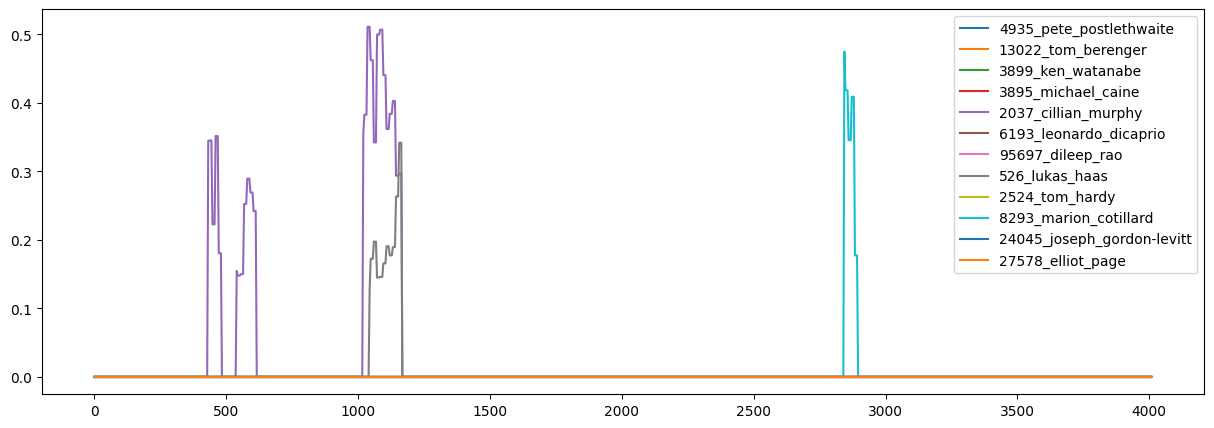

In [82]:
length_threshold = 12
sum_pred_value_threshold = 4

final_timeline = sqldf("""
    select
        predicted_tl.actor,
        frame_number,
        timestamp,
        
        length,
        max_pred_value,
        sum_pred_value,
        
        case
            when length >= {0} or sum_pred_value >= {1} then pred_value
            else 0
        end as pred_value
        
    from predicted_tl 
    left join summarized_timeline on predicted_tl.actor = summarized_timeline.actor
        and predicted_tl.frame_number between summarized_timeline.frame_number_from and summarized_timeline.frame_number_to

""".format(length_threshold,sum_pred_value_threshold))

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

for actor in pd.unique(final_timeline['actor']):
    plt.plot(final_timeline[final_timeline['actor'] == actor]['frame_number'], final_timeline[final_timeline['actor'] == actor]['pred_value'], label = actor)
#plt.xlim(400, 700) 
#plt.xlim(1000, 1200) 
#plt.xlim(1330, 1390)
#plt.xlim(300, 3000)
plt.legend()

In [ ]:
summarized_timeline